<a href="https://colab.research.google.com/github/ritwiks9635/New_Project_Ideas/blob/main/Image_Segmentation_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Segmentation**

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

#**Download Dataset**
original author of the dataset : https://github.com/VikramShenoy97/Human-Segmentation-Dataset

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 27.74 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [52]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [38]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [30]:
row = df.iloc[33]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

In [31]:
print(image.shape)
print(mask.shape)

(640, 480, 3)
(577, 433)


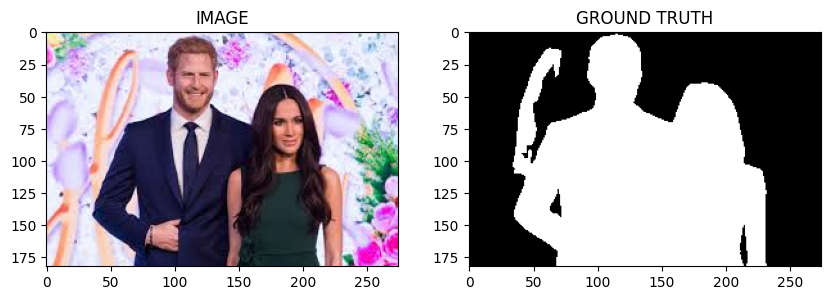

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [39]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [40]:
import albumentations as A

In [53]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

In [42]:
from torch.utils.data import Dataset

In [43]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape = (h, w)
    mask = np.expand_dims(mask, axis=-1)  # convert to shape = (h, w, c) w/ c=1

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # shift (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

    return image, mask

In [54]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [45]:
print("Size of Train set :: ", len(trainset))
print("Size of Valid set :: ", len(validset))

Size of Train set ::  232
Size of Valid set ::  58


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


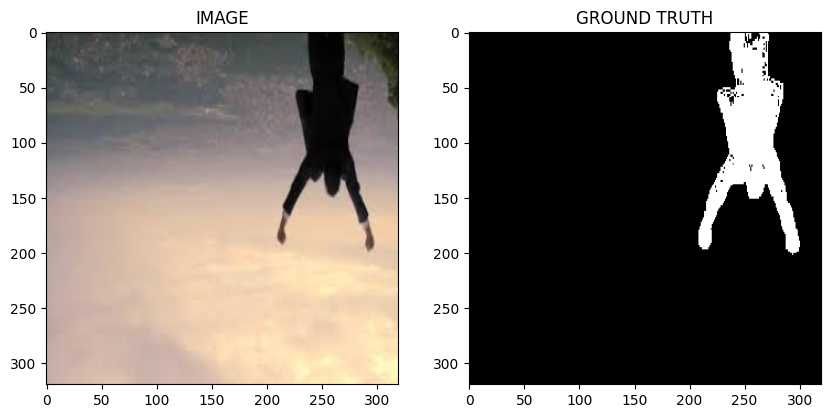

In [60]:
idx = 26

image, mask= trainset[idx]
print(image.shape, mask.shape)
helper.show_image(image, mask)

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [20]:
print("Total No of Batchs Train Looader :: ", len(trainloader))
print("Total No of Batchs Valid Loader :: ", len(validloader))

Total No of Batchs Train Looader ::  15
Total No of Batchs Valid Loader ::  4


In [ ]:
for image, mask in trainloader:
    print("One batch image shape ::", image.shape)
    print("One batch mask shape ::", mask.shape)
    break

#**Create Segmentation Model**
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentationModel, self).__init__() # usually do to create model in Pytorch

      self.arc = smp.Unet(
          encoder_name=ENCODER,
          encoder_weights=WEIGHTS,
          in_channels=3,
          classes=1,
          activation=None # output logits will be raw
      )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None: # must use != else does not run in training: "Boolean value of Tensor with more than one value is ambiguous"
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 141MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [25]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [26]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # convert back (1, C, H, W) -> (C, H, W)